<h1> Business Analytics</h1>
<h2> Marketing Analysis - A/B tests </h2>
<h3> <strong>Páginas com avaliações de usuários aumentam a quantidade de vendas? - A/B tests </strong></h3>

In [1]:
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

plt.style.use('fivethirtyeight')
plt.figure(1, figsize = (15, 6))
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -a "dijkstra001" --iversions

Author: dijkstra001

numpy     : 1.19.2
pandas    : 1.1.3
scipy     : 1.5.2
matplotlib: 3.3.2



In [3]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


<p> <strong style="color: blue">Variante A: </strong>Mostra o nº atual de comentários e avaliações de usuários. É a <strong>variante de controle</strong>.</p>
<strong style="color: red">Variante B: </strong>Não mostra os comentários e avaliações no site. É a <strong>variante de teste</strong>.</p>

<h2> Análise do conjunto de dados:</h2>

In [4]:
max_date = dataset['data'].max()
min_date = dataset['data'].min()
print(f'Data máxima: {max_date} e Data mínima: {min_date}')

Data máxima: 2020-01-30 e Data mínima: 2019-01-01


In [5]:
dataset.isnull().sum()

id          0
variante    0
compra      0
data        0
dtype: int64

In [6]:
dataset.id.value_counts().sum()

55000

In [7]:
dataset.compra.value_counts()

False    46416
True      8584
Name: compra, dtype: int64

In [8]:
dataset.variante.value_counts()

A    50000
B     5000
Name: variante, dtype: int64

<h2> Calculando probabilidades de:</h2>

<p><strong>1 - Probabilidade de um usuário visualizar a variante A:</strong></p>

In [9]:
round((dataset[dataset.variante == 'A'].shape[0] / dataset.shape[0]) * 100, 2)

90.91

<p><strong>2 - Probabilidade de um usuário visualizar a variante B:</strong></p>

In [10]:
round((dataset[dataset.variante == 'B'].shape[0] / dataset.shape[0]) * 100, 2)

9.09

<p><strong>3 - Se um indivíduo estava no grupo de controle (variante A), qual a probabilidade de conversão de compra:</strong></p>

In [11]:
round((dataset[dataset.variante == 'A'].compra.mean()) * 100, 2)

15.21

<p><strong>Total de compras realizadas:</strong></p>

In [12]:
dataset.compra.sum()

8584

<p><strong>Total de compras realizadas quando a variante era A:</strong></p>

In [13]:
dataset[dataset.variante == 'A'].compra.sum()

7603

<p><strong>Total de compras realizadas quando a variante era B:</strong></p>

In [14]:
dataset[dataset.variante == 'B'].compra.sum()

981

<p><strong>4 - Probabilidade de conversão de compras, independente da variante recebida:</strong></p>

In [15]:
round((dataset.compra.mean()) * 100, 2)

15.61

<p><strong>5 - Probabilidade de conversão de compras, dado uma variante de controle:</strong></p>

In [16]:
A = round((dataset[dataset.variante == 'A'].compra.mean()) * 100, 2)
print(A)

15.21


<p><strong>6 - Probabilidade de conversão de compras, dado uma variante de tratamento:</strong></p>

In [17]:
B = round((dataset[dataset.variante == 'B'].compra.mean()) * 100, 2)
print(B)

19.62


<p> Com base nos cálculos de probabilidades realizados, precisamos analisar se temos evidências suficientes para determinarmos se a variável de teste pode causar um aumento de conversão de compras. Os dados demonstraram que, <strong>apesar de pouca visibilidade da variante B</strong>, a taxa de conversão dessa variante é superior à variante de controle (A). </p>
<p> Nesse sentido, é necessário uma análise mais detalhada para identificarmos os padrões desse comportamento.</p>

<h1 style="color: blue">Tarefa 1 - Configurando o experimento</h1>
<p>Considere que você precisa tomar uma decisão apenas com base nos dados fornecidos. Se você quiser assumir que a variante A é a melhor, a menos que a nova variante prove ser definitivamente melhor em uma taxa de erro <strong>Tipo I de 5%</strong>, quais deveriam
ser as suas hipóteses nula e alternativa?</p>
<ul>
    <li>H0: PB - PA = 0</li>
    <li>H1: PB - PA > 0</li>
</ul>

<p><strong style="color: green">H0</strong> nos diz que a diferença de probabilidade dos dois grupos é igual a zero.</p>
<p><strong style="color: red">H1</strong> nos diz que a diferença de probabilidade dos dois grupos é maior que zero.</p>

<h3 style="color: blue">Pré-Processamento dos dados:</h3>

In [18]:
def extract_date(x):
    return x[:7]

dataset['ano_mes'] = dataset['data'].apply(extract_date)
dataset.head()

,id,variante,compra,data,ano_mes
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09


In [19]:
dataset_2020 = dataset[dataset['ano_mes'] == '2020-01']
dataset_2020.head()

,id,variante,compra,data,ano_mes
5,0x792f1d,A,False,2020-01-14,2020-01
7,0x724b78,B,False,2020-01-23,2020-01
9,0x684bf9,A,False,2020-01-17,2020-01
10,0x6394dc,A,False,2020-01-06,2020-01
11,0x625f5d,A,False,2020-01-05,2020-01


<h3 style="color: blue">Criação do baseline:</h3>
<ul>
    <li><strong style="color: green">A</strong> será o grupo de controle.</li>
    <li><strong style="color: red">B</strong> será o grupo de teste</li>
</ul>

In [20]:
dataset_ab = dataset_2020[['variante', 'compra']]
dataset_ab.columns = ['grupo', 'conversao']
dataset_ab.head()

,grupo,conversao
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [21]:
dataset_ab_summary = dataset_ab.pivot_table(values = 'conversao', index = 'grupo', aggfunc = np.sum)
dataset_ab_summary.head()

,conversao
grupo,
A,587
B,981


In [22]:
dataset_ab_summary['total'] = dataset_ab.pivot_table(values = 'conversao', index = 'grupo', aggfunc = lambda x : len(x))
dataset_ab_summary['taxa %'] = round(dataset_ab.pivot_table(values = 'conversao', index = 'grupo') * 100, 2)
dataset_ab_summary.head()

,conversao,total,taxa %
grupo,,,
A,587,3821,15.36
B,981,5000,19.62


In [23]:
conversion_A = dataset_ab_summary['conversao'][0]
total_A = dataset_ab_summary['total'][0]
tax_A = dataset_ab_summary['taxa %'][0]
print(f'Valores do grupo A:\nConversão: {conversion_A}\nTotal: {total_A}\nTaxa: {tax_A}')

Valores do grupo A:
Conversão: 587
Total: 3821
Taxa: 15.36


In [24]:
conversion_B = dataset_ab_summary['conversao'][1]
total_B = dataset_ab_summary['total'][1]
tax_B = dataset_ab_summary['taxa %'][1]
print(f'Valores do grupo B:\nConversão: {conversion_B}\nTotal: {total_B}\nTaxa: {tax_B}')

Valores do grupo B:
Conversão: 981
Total: 5000
Taxa: 19.62


In [25]:
base_conversion = tax_A / 100

# Efeito mínimo detectável:
min_effect = round(tax_B - tax_A, 2)
min_effect

4.26

<h1 style="color: blue">Tarefa 2 - Realizando o teste de hipóteses</h1>
<p>Executamos o teste de hipóteses e registramos a taxa de sucesso de cada grupo.</p>
<p><strong>Poder estatístico = </strong>1 - &#914; (Beta)</p>
<ul>
    <li>Alfa: 0.05</li>
    <li>Beta: 0.2</li>
</ul>

In [26]:
alfa = 0.05
beta = 0.2
n = 50000

binom_test = scs.binom(n, p = base_conversion)
binom_test_mde = scs.binom(n, p = (base_conversion + (min_effect / 100)))

<BarContainer object of 50001 artists>

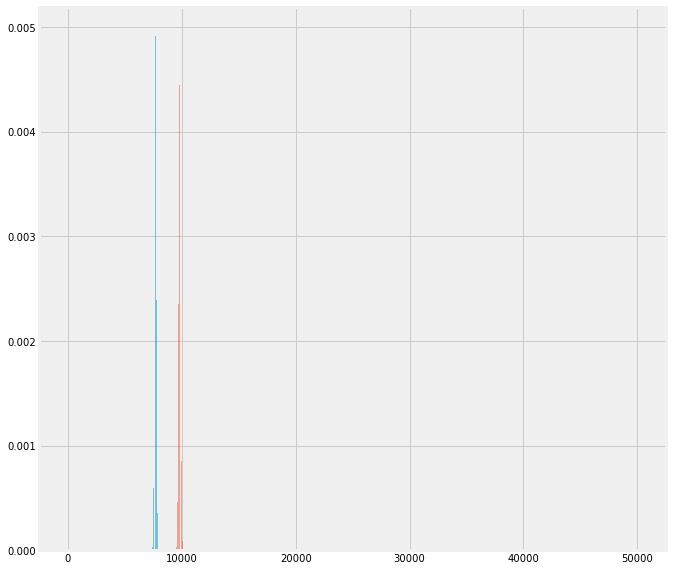

In [27]:
fig, ax = plt.subplots(figsize = (10, 10))
x = np.linspace(0, int(n), int(n) + 1)
ax.bar(x, binom_test.pmf(x), alpha = 0.5)
ax.bar(x, binom_test_mde.pmf(x), alpha = 0.5)

<h1 style="color: blue">Tarefa 3 - Plot da Distribuição</h1>
<p>Criação do plot da distribuição das duas amostras, com o objetivos de compararmos suas diferenças e analisarmos os resultados.</p>

Text(0, 0.5, 'Probabilidade')

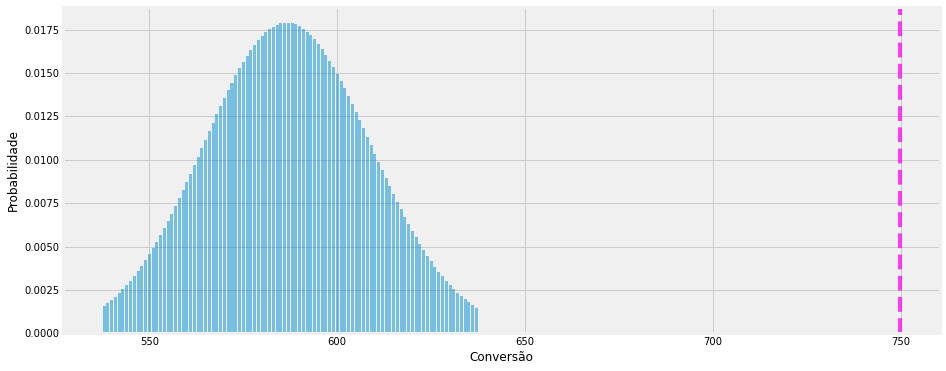

In [28]:
fig, ax = plt.subplots(figsize = (14, 6))

# Teste de A:
x = np.linspace(conversion_A - 49, conversion_A + 50, 100)
y = scs.binom(total_A, (tax_A / 100)).pmf(x)
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = (tax_B / 100) * total_A, c = 'magenta', alpha = 0.75, linestyle = '--')
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

<BarContainer object of 100 artists>

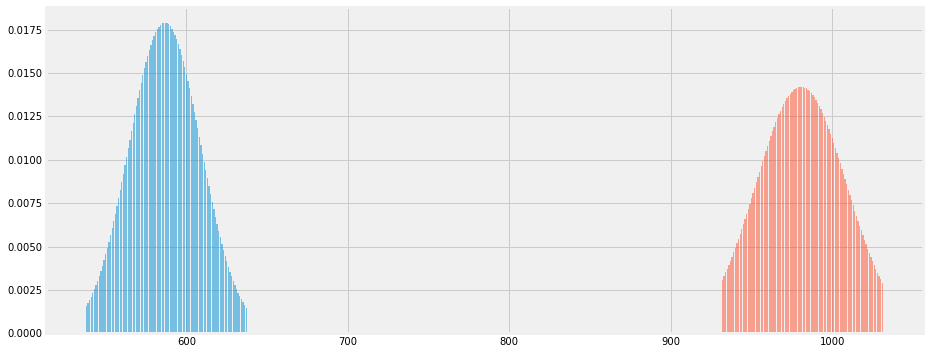

In [29]:
fig, ax = plt.subplots(figsize = (14, 6))

# Gráfico de A:
xA = np.linspace(conversion_A - 49, conversion_A + 50, 100)
yA = scs.binom(total_A, (tax_A / 100)).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Gráfico de B:
xB = np.linspace(conversion_B - 49, conversion_B + 50, 100)
yB = scs.binom(total_B, (tax_B / 100)).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

In [30]:
p_A = (tax_A / 100)
p_B = (tax_B / 100)

n_A = total_A
n_B = total_B

# Calculando o erro padrão:
se_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(total_A)
se_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(total_B)

print(f'Erro padrão de A: {se_A}\nErro padrão de B: {se_B}')

Erro padrão de A: 0.005833039486124652
Erro padrão de B: 0.0056161474339621814


Text(0, 0.5, 'PDF - Probability Density Function')

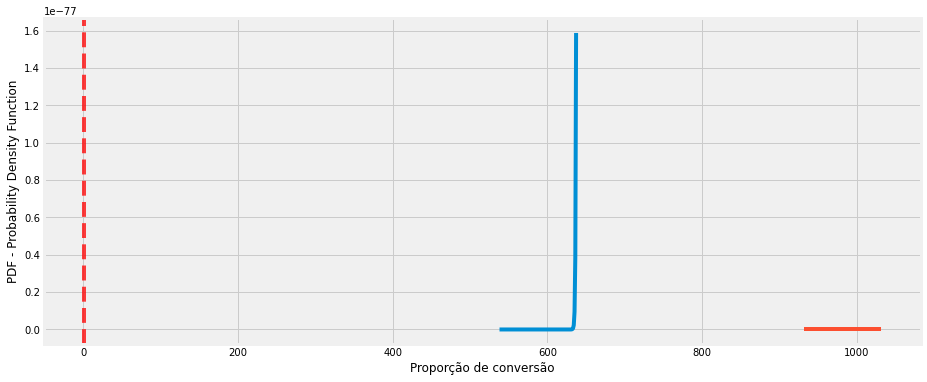

In [31]:
# Plot das distribuições das hipóteses nula e alternativa:

fig, ax = plt.subplots(figsize = (14, 6))

x = np.linspace(0, p_B - p_A, 100)

# Distribuição de A:
yA = scs.norm(p_A, se_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x = p_A, c = 'red', alpha = 0.5, linestyle = '--')

# Distribuição de B:
yB = scs.norm(p_B, se_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x = p_B, c = 'red', alpha = 0.5, linestyle = '--')

plt.xlabel('Proporção de conversão')
plt.ylabel('PDF - Probability Density Function')

As linhas contínuas representam a taxa de conversão média para cada grupo. A distância entre a linha azul e a linha vermelha é igual à diferença média entre o grupo de controle e teste. 

### Verificando a Hipótese Nula e a Hipótese Alternativa

Vamos começar relembrando a definição da hipótese nula e da hipótese alternativa.

**A hipótese nula é a posição de que a mudança no design feito para o grupo de teste resultaria em nenhuma mudança na taxa de conversão.**

**A hipótese alternativa é a posição oposta de que a mudança no design do grupo de teste resultaria em uma melhoria (ou redução) na taxa de conversão.**

A hipótese nula será uma distribuição normal com uma média de zero e um desvio padrão igual ao erro padrão agrupado.

A hipótese alternativa tem o mesmo desvio padrão que a hipótese nula, mas a média estará localizada na diferença na taxa de conversão, d_hat. Isso faz sentido porque podemos calcular a diferença nas taxas de conversão diretamente dos dados, mas a distribuição normal representa possíveis valores que nosso experimento poderia ter nos dado.

Fórmula para o cálculo de z:

$$ z = \frac{(\bar{x_1}-\bar{x_2})-D_0}{\sqrt{\sigma_1^{2}/n_1+\sigma_{2}^{2}/n_2}} $$

$$ z = \frac{(\hat{p_1}-\hat{p_2})-0}{\sqrt{\hat{p}\hat{q}(\frac{1}{n_1}+\frac{1}{n_2})}}$$

In [32]:
pooled_prob = (p_A * n_A + p_B * n_B) / (n_A + n_B)
z = (p_B - p_A) / (pooled_prob * (1 - pooled_prob) * (1 / n_A + 1 / n_B)) ** 0.5
z

5.185855491209477

<h3 style="color: blue">Plot da Distribuição de Probabilidade</h3>

In [33]:
def pooled_probability(n_A, n_B, x_A, x_B):
    return (x_A + x_B) / (n_A + n_B)

def pooled_se(n_A, n_B, x_A, x_B):
    p_hat = pooled_probability(n_A, n_B, x_A, x_B)
    se = np.sqrt(p_hat * (1 - p_hat) * (1 / n_A + 1 / n_B))
    return se

def z_value(sig_level = 0.05, two_tailed = True):
    z_distrib = scs.norm()
    
    if two_tailed:
        sig_level = sig_level / 2
        area = 1 - sig_level
    else:
        area = 1 - sig_level
    
    return z_distrib.ppf(area)

In [34]:
def confidence_interval(sample_mean = 0, sample_std = 1, sample_size = 1, sig_level = 0.05):
    z = z_value(sig_level)
    
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)
    
    return (left, right)

In [35]:
def plot_CI(ax, mu, s, sig_level = 0.05, color = 'grey'):
    left, right = confidence_interval(sample_mean = mu, sample_std = s, sig_level = sig_level)
    
    ax.axvline(left, c = color, linestyle = '--', alpha = 0.5)
    ax.axvline(right, c = color, linestyle = '--', alpha = 0.5)

In [36]:
def plot_norm_distrib(ax, mu, std, with_CI = False, sig_level = 0.05, label = None):
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    y = scs.norm(mu, std).pdf(x)
    
    ax.plot(x, y, label = label)
    
    if with_CI:
        plot_CI(ax, mu, std, sig_level = sig_level)

In [37]:
def plot_H0(ax, stderror):
    plot_norm_distrib(ax, 0, stderror, label = 'H0 - Hipótese Nula')
    plot_CI(ax, mu = 0, s = stderror, sig_level = 0.05)

def plot_H1(ax, stderror, d_hat):
    plot_norm_distrib(ax, d_hat, stderror, label = 'H1 - Hipótese Alternativa')

In [38]:
def show_area(ax, d_hat, stderror, sig_level):
    left, right = confidence_interval(sample_mean = 0, sample_std = stderror, sig_level = sig_level)
    
    x = np.linspace(-12 * stderror, 12 * stderror, 1000)
    
    h0_value = ab_dist(stderror, 'controle')
    h1_value = ab_dist(stderror, d_hat, 'teste')
    
    ax.fill_between(x, 0, h1_value.pdf(x), color = 'green', alpha = 0.25, where = (x > right))
    ax.text(-3 * stderror, h0_value.pdf(0), 'power = {0:.3f}'.format(1 - h1_value.cdf(right)), 
            fontsize = 12, ha = 'right', color = 'k')

In [39]:
def ab_dist(stderror, d_hat = 0, group_type = 'controle'):
    if group_type == 'controle':
        sample_mean = 0
    elif group_type == 'teste':
        sample_mean = d_hat
    
    return scs.norm(sample_mean, stderror)

In [40]:
def p_value(n_A, n_B, p_A, p_B):
    return scs.binom(n_A, p_A).pmf(n_B * p_B)

In [41]:
def ab_plot(n_A, n_B, bcr, d_hat, sig_level = 0.05, show_p_value = False, show_legend = True):
    fig, ax = plt.subplots(figsize = (14, 8))
    
    x_A = bcr * n_A
    x_B = (bcr + d_hat) * n_B
    stderror = pooled_se(n_A, n_B, x_A, x_B)
    
    plot_H0(ax, stderror)
    plot_H1(ax, stderror, d_hat)
    
    ax.set_xlim(-8 * stderror, 8 * stderror)
    
    show_area(ax, d_hat, stderror, sig_level)
    
    if show_p_value:
        h0_value = ab_dist(stderror, 'controle')
        p_val = p_value(n_A, n_B, bcr, bcr + d_hat)
        ax.text(3 * stderror, h0_value.pdf(0), 'Valor p = {0:.6f}'.format(p_val), fontsize = 14, ha = 'left')
    
    if show_legend:
        plt.legend()
    
    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

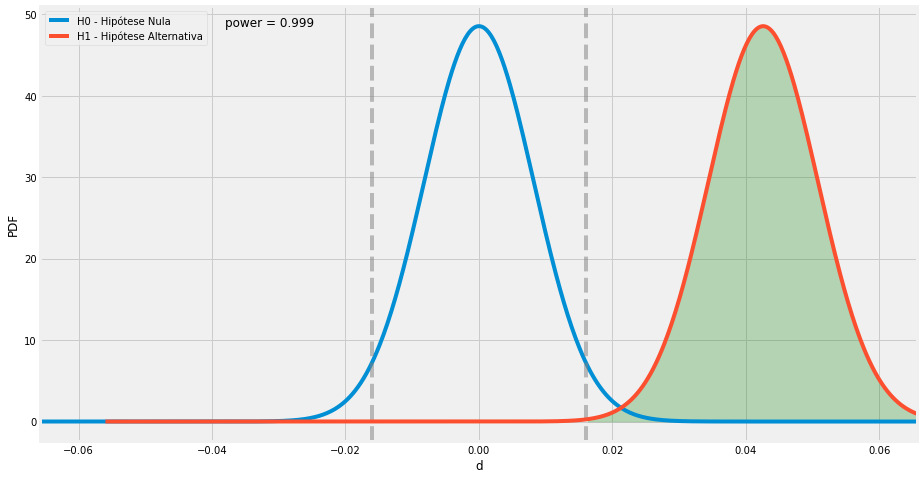

In [42]:
n = n_A + n_B
base_conversion = p_A
d_hat = p_B - p_A
ab_plot(n_A, n_B, base_conversion, d_hat)

<h1 style="color: blue">Tarefa 4 - Influência do Tamanho da amostra no teste A/B</h1>

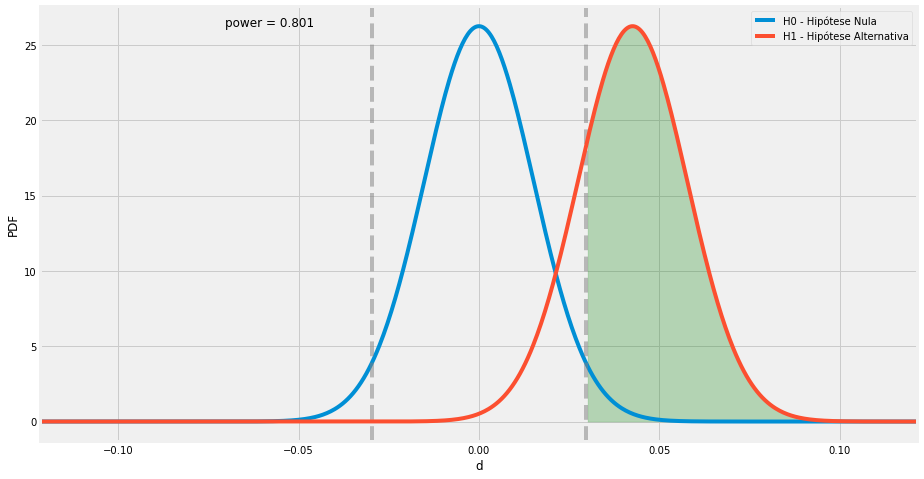

In [43]:
ab_plot(1250, 1250, base_conversion, d_hat)